# Part II

In [132]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import trange
import cvxpy as cp

In [88]:
def k(x,y):
  # Returns the result of Euclidiean kernel k(x,y) 
  return np.exp(-np.linalg.norm(x-y)**2)

def compute_K(X,Y):
    # Computes the matrix K = (k(x,y))
    return np.array([[k(Xi,Yj) for Yj in Y] for Xi in X])

def plot_f(alpha,x_selected,x):
    # Returns the evaluation of the function f defined by alpha at points x
    K = compute_K(x,x_selected)
    return K@alpha

def g(alpha,x_m_points,X,Y,sigma):
    K_mm = compute_K(x_m_points,x_m_points)
    K_nm = compute_K(X.flatten(),x_m_points)
    return alpha.T@K_mm@alpha/2 +  np.linalg.norm(Y.flatten() - K_nm@alpha,ord=2)**2/(2*sigma**2)

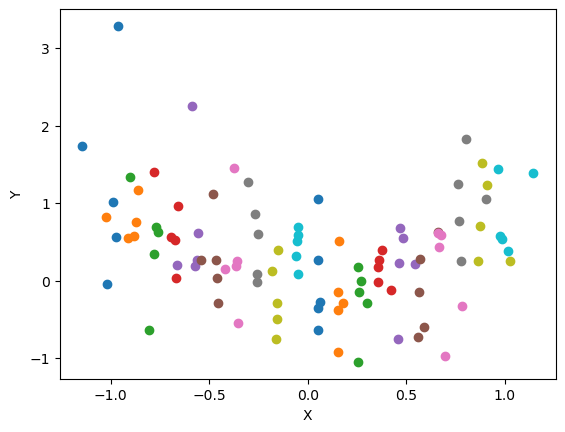

In [6]:
n = 100
m = 10
a = 5

with open('../databases/second_database.pkl', 'rb') as f:
    X, Y = pkl.load(f)
    
plt.plot(X,Y,'o')
plt.xlabel("X")
plt.ylabel("Y")

X = np.array(X)
Y = np.array(Y)

x_m_points=np.linspace(-1,1,m)

In [91]:
K_mm = compute_K(x_m_points,x_m_points)
K_nm = compute_K(X.flatten(),x_m_points)
true_alpha_linalg = np.linalg.solve((sigma**2)*K_mm + K_nm.T@K_nm,K_nm.T@Y.flatten())

In [92]:
g(true_alpha_linalg,x_m_points,X,Y,sigma)

74.68149340807943

## FedAvg

<img src="formules.jpg"
     alt="Markdown Monster icon"
     style="float: center; margin-right: 10px;height:1000px" />

The gradient of $g_b$ will be :
$$\nabla g_b(\alpha) = \frac{1}{10}\frac{1}{5} K_{mm}\alpha - \frac{1}{\sigma^2}\sum_{j \in b} K_{(j)m}^T(y_j - K_{(j)m}\alpha)$$ 

For the `FedAvg` algorithm, the update of $\alpha_{k+1}$ is done as follows :
$$\alpha_{k+1} = \sum_{c = 1}^C \frac{N_c}{\sum_{c'=1}^C N_{c'}}\alpha_{k+1}^c$$
In our case, all clients have the same number of points : $N$, so the coefficient $\frac{N_c}{\sum_{c'=1}^C N_{c'}} = \frac{N}{CN} = \frac{1}{C}$.

We need a diminishing learning rate so we choose as learning rate the sequence : $(1/k)_{k\in \mathbb{N}^*}$.

In [13]:
B = 10
index_client = 0
batches = np.array_split(X[index_client],B)
random_batch = np.random.randint(B)

In [16]:
def compute_K_jm(x_m_points,x_j):
    return np.array([k(x_m_points[i],x_j) for i in range(len(x_m_points))])

In [161]:
def client_update(X,Y,index_client,E,sigma,alpha_0,K_mm):
    m = K_mm.shape[0]
    alpha = np.copy(alpha_0)
    for k in range(E):
        batches_X = np.array_split(X[index_client],B)
        batches_Y = np.array_split(Y[index_client],B)
        random_batch = np.random.randint(B)
        nabla = (1/50)*K_mm@alpha
        for j in range(len(batches_X[random_batch])):
            K_jm = compute_K_jm(x_m_points,batches_X[random_batch][j])
            nabla -= (batches_Y[random_batch][j] - K_jm@alpha)*K_jm.T/(sigma**2)
            
        alpha -= (1/(k+500))*nabla
    return alpha

In [162]:
def FedAvg(X,Y,B,E,C,sigma,nb_it,K_mm):
    nb_clients = X.shape[0]
    m = K_mm.shape[0]

    alpha = np.zeros(m)
    g_vals = []
    t = trange(nb_it)
    for k in t:
        selected_clients = np.random.choice(np.array(range(nb_clients)),size=C, replace=False)
        alpha_i = np.zeros((C,m))
        for i in range(C):
            alpha_i[i] = client_update(X,Y,selected_clients[i],E,sigma,alpha,K_mm)
        
        #We need to update x_{k+1} = \sum_{c = 1}^C
        alpha = np.sum(alpha_i,axis=0)/C
        g_val = g(alpha,x_m_points,X,Y,sigma)
        g_vals.append(g_val)
        t.set_postfix(g_val=g_val)

    return alpha, g_vals

In [163]:
K_mm = compute_K(x_m_points,x_m_points)
B = 10
E = 10
C = 3
nb_it = 1000
sigma = 0.5
alpha_res, g_vals = FedAvg(X,Y,B,E,C,sigma,nb_it,K_mm)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [164]:
alpha_res

array([ 0.65286953,  0.50984113,  0.27006739, -0.04055304, -0.34439476,
       -0.5198149 , -0.45275891, -0.10876832,  0.42695112,  0.97894899])

In [165]:
g(alpha_res,x_m_points,X,Y,sigma)

75.94161331724285

Text(0.5, 1.0, 'Plot of $f$ using FedAvg to solve the problem')

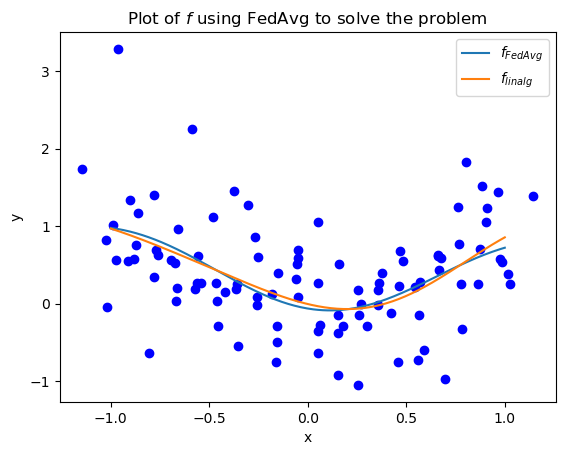

In [166]:
s = 250
x_prime = np.linspace(-1,1,s)
f_approx_fedavg = plot_f(alpha_res,x_m_points,x_prime)
f_true_linalg = plot_f(true_alpha_linalg,x_m_points,x_prime)
plt.plot(X,Y,'bo')
plt.plot(x_prime,f_approx_fedavg, label= "$f_{FedAvg}$")
plt.plot(x_prime,f_true_linalg, label= "$f_{linalg}$")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Plot of $f$ using FedAvg to solve the problem")

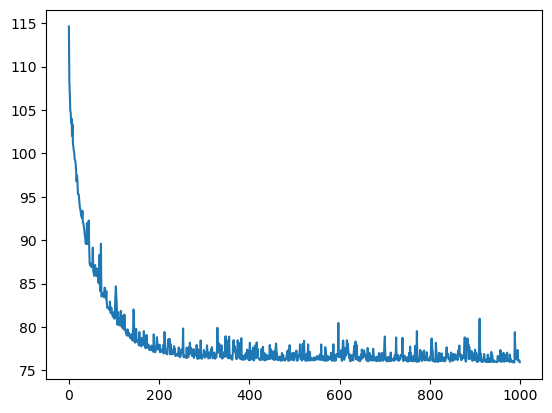

In [167]:
plt.plot(g_vals)